<a href="https://colab.research.google.com/github/MadhurimaNayak/mpi4py_airplanesafety/blob/main/airlinewithmpi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.6-cp310-cp310-linux_x86_64.whl size=2746317 sha256=6973461abffbdeaad94d5b22fd0b8342941df5f8966bfb3beacabb93acaed5c3
  Stored in directory: /root/.cache/pip/wheels/4c/ca/89/8fc1fb1c620afca13bb41c630b1f948bbf446e0aaa4b762e10
Successfully built mpi4py


Rank: 0, X_train shape: (44, 7), y_train shape: (44,)
Rank: 0, training on full dataset


<timed exec>:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


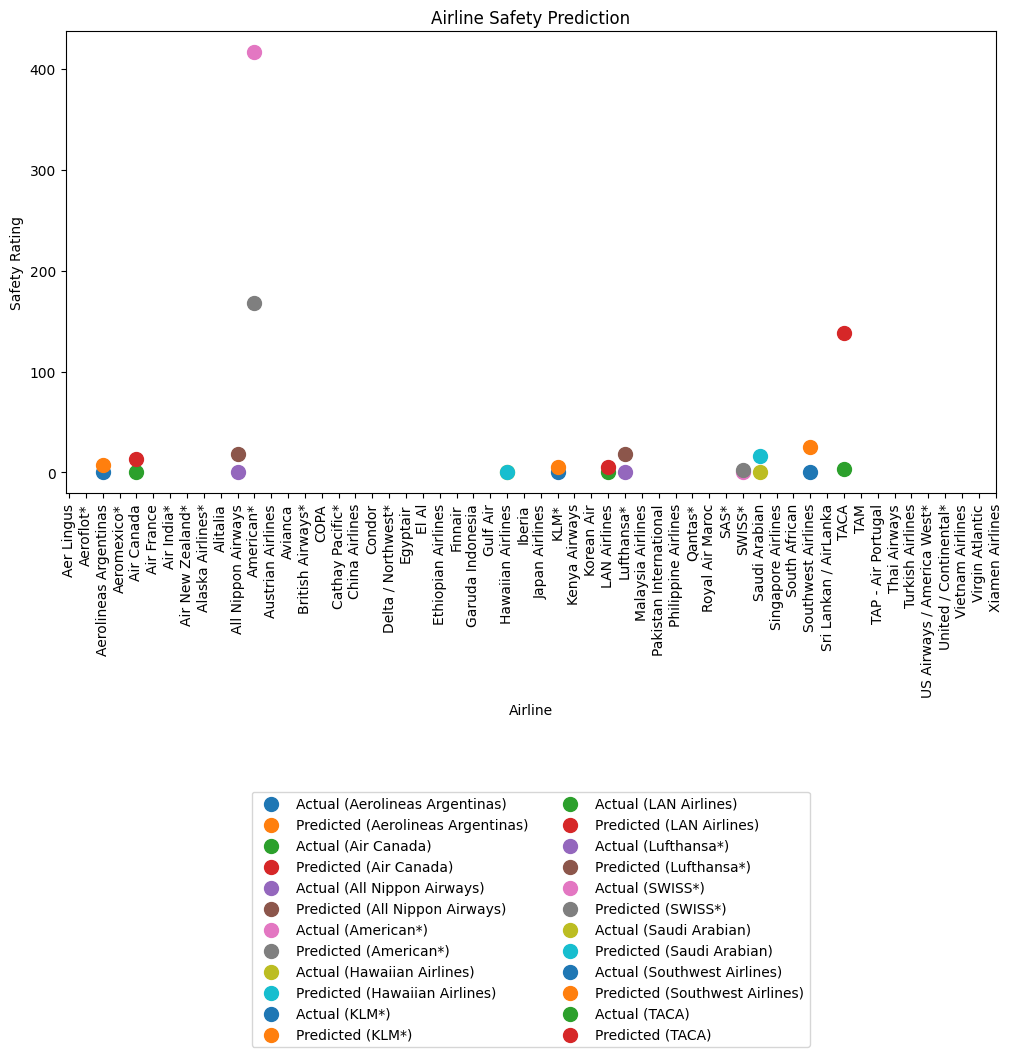

CPU times: user 2.21 s, sys: 118 ms, total: 2.33 s
Wall time: 2.71 s


In [ ]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpi4py import MPI

dataset = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/airline-safety/airline-safety.csv')

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset['airline'] = label_encoder.fit_transform(dataset['airline'])

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Check the shape of the input data
print(f"Rank: {rank}, X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Define the model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Train the model
if rank == 0:
    print(f"Rank: {rank}, training on full dataset")
    model.fit(X_train, y_train)
else:
    print(f"Rank: {rank}, training on subset: {X_train[rank-1::size].shape}, {y_train[rank-1::size].shape}")
    model.fit(X_train[rank-1::size], y_train[rank-1::size])

# Evaluate the model
y_pred = model.predict(X_test)

# Plot the results
num_airlines = len(label_encoder.classes_)
fig, ax = plt.subplots(figsize=(12, 6))

# Iterate over all the unique airlines
for i in range(num_airlines):
    actual_idx = np.where(X_test[:, 0] == i)[0]
    pred_idx = np.where(X_test[:, 0] == i)[0]

    if len(actual_idx) > 0 and len(pred_idx) > 0:
        ax.scatter(i, y_test[actual_idx[0]], label=f'Actual ({label_encoder.classes_[i]})', s=100)
        ax.scatter(i, y_pred[pred_idx[0]], label=f'Predicted ({label_encoder.classes_[i]})', s=100)

ax.set_xticks(range(num_airlines))
ax.set_xticklabels(label_encoder.classes_, rotation=90)
ax.set_title('Airline Safety Prediction')
ax.set_xlabel('Airline')
ax.set_ylabel('Safety Rating')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.63), ncol=2)
plt.tight_layout()
plt.show()

